In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
from pylab import *
from qutip import *
from matplotlib import cm
import imageio
from pathos.multiprocessing import ProcessingPool as Pool

def plot_points(b):
    # -X and Y data are switched for plotting purposes
    for k in range(len(b.points)):
        num = len(b.points[k][0])
        dist = [sqrt(b.points[k][0][j] ** 2 +
                     b.points[k][1][j] ** 2 +
                     b.points[k][2][j] ** 2) for j in range(num)]
        if any(abs(dist - dist[0]) / dist[0] > 1e-12):
            # combine arrays so that they can be sorted together
            zipped = list(zip(dist, range(num)))
            zipped.sort()  # sort rates from lowest to highest
            dist, indperm = zip(*zipped)
            indperm = array(indperm)
        else:
            indperm = arange(num)
        if b.point_style[k] == 's':
            b.axes.scatter(
                real(b.points[k][1][indperm]),
                - real(b.points[k][0][indperm]),
                real(b.points[k][2][indperm]),
                s=b.point_size[mod(k, len(b.point_size))],
                alpha=1,
                edgecolor='none',linewidths=0,
                zdir='z',
                color=b.point_color[mod(k, len(b.point_color))],
                marker=b.point_marker[mod(k, len(b.point_marker))])

        elif b.point_style[k] == 'm':
            pnt_colors = array(b.point_color *
                               int(ceil(num / float(len(b.point_color)))))

            pnt_colors = pnt_colors[0:num]
            pnt_colors = list(pnt_colors[indperm])
            marker = b.point_marker[mod(k, len(b.point_marker))]
            s = b.point_size[mod(k, len(b.point_size))]
            b.axes.scatter(real(b.points[k][1][indperm]),
                              -real(b.points[k][0][indperm]),
                              real(b.points[k][2][indperm]),
                              s=s, alpha=1, edgecolor='none',linewidths=0,
                              zdir='z', color=pnt_colors,
                              marker=marker)

        elif b.point_style[k] == 'l':
            color = b.point_color[mod(k, len(b.point_color))]
            b.axes.plot(real(b.points[k][1]),
                           -real(b.points[k][0]),
                           real(b.points[k][2]),
                           alpha=0.75, zdir='z',lw=5,
                           color=color)

def plot_bloch(states):

    b = Bloch()
    b.plot_points=lambda: plot_points(b)
    length = len(states)
    # normalize colors to the length of data ##
    nrm = mpl.colors.Normalize(0,length)
    colors = cm.winter(nrm(range(length))) # options: brg, cool, summer, winter, autumn

    ## add data points from expectation values ##
    b.add_points([expect(sigmax(), states),
                  expect(sigmay(), states),
                  expect(sigmaz(), states)],'m')

    # customize sphere properties ##
    b.point_color = list(colors)
    b.point_marker = ['o'] # options: o, s, d, ^
    b.point_size = [20]
    b.zlpos = [1.1,-1.2]
    b.show()
    
    
def animate_bloch(states, duration=0.1, save_all=False):

    b = Bloch()
    b.vector_color = ['r']
    b.view = [-40,30]
    images=[]
    try:
        length = len(states)
    except:
        length = 1
        states = [states]
    ## normalize colors to the length of data ##
    nrm = mpl.colors.Normalize(0,length)
    colors = cm.cool(nrm(range(length))) # options: cool, summer, winter, autumn etc.

    ## customize sphere properties ##
    b.point_color = list(colors) # options: 'r', 'g', 'b' etc.
    b.point_marker = ['o']
    b.point_size = [30]
    
    for i in range(length):
        b.clear()
        b.add_states(states[i])
        b.add_states(states[:(i+1)],'point')
        if save_all:
            b.save(dirc='tmp') #saving images to tmp directory in current working directory b=Bloch()
            filename="tmp/bloch_%01d.png" % i
        else:
            filename='temp_file.png'
            b.save(filename)
        images.append(imageio.imread(filename))
    imageio.mimsave('bloch_anim.gif', images, duration=duration)

In [41]:
animate_bloch(states2, duration=0.05, save_all=True)

## Fluxonium gate definitions

X pulse: 2.1656249366575766, Z pulse: 15.1423305995572655, Total: 19.4735804728724204
Final avg. photon = 0.9999999999998334
final state
[[4.67483571e-08+4.05510098e-07j]
 [1.00000000e+00+1.02617895e-07j]]


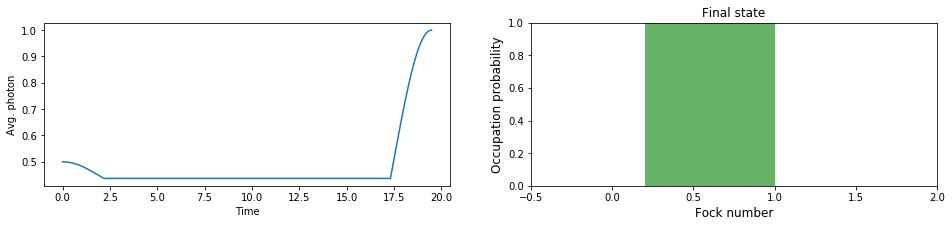

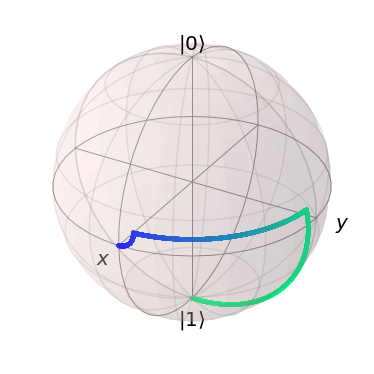

In [31]:
def compute_expectation(state):
    return np.array([expect(sigma, state) for sigma in [sigmax(),sigmay(),sigmaz()]])


def Xpiby2_square(args, show_plot=True):
    # Rx[pi/2]= Ry[pi/2].Rz[pi/2].Ry[-pi/2]

    args['A'] = -1*args['A']
    tlist1, states1 = Ypiby2_square(args, show_plot=False)
    
    args['psi0'] = states1[-1]
    args['x_pulse'] = 0
    args['z_pulse'] = args['Zpi']/2
    tlist2, states2 = evolve_fluxonium_square(args, show_plot=False)
    tlist2 = tlist2 + tlist1[-1]
    
    args['psi0'] = states2[-1]
    args['A'] = -1*args['A']
    tlist3, states3 = Ypiby2_square(args, show_plot=False)
    tlist3 = tlist3 + tlist2[-1]
    
    tlist = [*tlist1, *tlist2, *tlist3]
    states = states1 + states2 + states3
    
    if show_plot:
        sm = destroy(2)
        fig, axes = plt.subplots(1, 2, figsize=(16,3))
        axes[0].plot(tlist, expect(sm.dag() * sm, states))
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Avg. photon')
        plot_fock_distribution(states3[-1], fig=fig, ax=axes[1], title="Final state");
        print('Final avg. photon = %f' %(expect(sm.dag() * sm, states3[-1])))
        plot_bloch(states)
    else:
        return tlist, states
    
    
def Ypi_square(args, show_plot=True):
    # Ry[pi]= Rx[-x, r].Rz[pi - z r].Rx[x, r]
    
    def optx(r):
        return math.acos(-r**2)/sqrt(1 + r**2)

    def optz(r):
        return (2/r) * math.atan(r/sqrt(1 - r**2))

    zbyx_rate = args['Xpi']/args['Zpi']/args['A'] # Xpi = pi length when A = 1
    args['x_pulse'] = optx(zbyx_rate) / np.pi * args['Xpi']/args['A']
    args['z_pulse'] = (np.pi - optz(zbyx_rate)*zbyx_rate) / np.pi * args['Zpi']

    if show_plot:
        evolve_fluxonium_square(args,show_plot=show_plot)
    else:
        tlist, states = evolve_fluxonium_square(args,show_plot=show_plot)
        return tlist, states

    
def Ypiby2_triangular(args, show_plot=True):
    # Ry[pi/2]= Rx[-x, r].Rz[z].Rx[x, r], valid for 0<= r <= sqrt(2) - 1 = 0.414

    def optx(r):
        return math.acos(-r*(1+r)/(1-r))/sqrt(1 + r**2)

    def optz(r):
        return 2 * math.atan(sqrt(1-2*r-2*r**3-r**4) / ((1+r)*sqrt(1 + r**2)))

    zbyx_rate = args['Xpi']/args['Zpi']/args['A']
    args['x_pulse'] = optx(zbyx_rate) / pi * args['Xpi']/args['A']
    args['z_pulse'] = optz(zbyx_rate) / pi * args['Zpi']

    if show_plot:
        evolve_fluxonium_triangular(args,show_plot=show_plot)
    else:
        tlist, states = evolve_fluxonium_triangular(args,show_plot=show_plot)
        return tlist, states
#ENDDEF


def evolve_fluxonium_triangular(args, show_plot=False):
    ''' Net zero flux pulse: +ve X, Z, -X pulse '''
    
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = + pi/args['Zpi'] * sz/2
    H1 = + pi/args['Xpi'] * sx/2

    x_pulse = args['x_pulse']
    z_pulse = args['z_pulse']
    A = 2*args['A'] # X-drive strength, 2 times to keep similar with a square pulse

    def H1_coeff(t, args):
        # First +ve triangle
        if t<(x_pulse/2):
            return A * 2*t/x_pulse
        elif t>=(x_pulse/2) and t<x_pulse:
            return A * (2 - 2*t/x_pulse)

        # Z-rotation only
        elif t>=x_pulse and t<x_pulse + z_pulse:
            return 0

        # Second -ve triangle
        elif t>=x_pulse + z_pulse and t<3/2*x_pulse + z_pulse:
            return -A * 2*(t - x_pulse - z_pulse)/x_pulse
        else:
            return -A * (2 - 2*(t - x_pulse - z_pulse)/x_pulse)
    
    Ht = [H0, [H1, H1_coeff]]
    
    Tend = 2*x_pulse + z_pulse
    tlist = np.linspace(0, Tend, args['Tpoints'])

    output = mesolve(Ht, psi0, tlist, args['c_ops'], [], args = args)
    
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(16,3))
        axes[0].plot(tlist, expect(sm.dag() * sm, output.states))
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Avg. photon')
        plot_fock_distribution(output.states[-1], fig=fig, ax=axes[1], title="Final state");

        print("X pulse: {:.16f}, Z pulse: {:.16f}, Total: {:.16f}".format(x_pulse,z_pulse,Tend))
        print("Final avg. photon = {:.16f}".format(expect(sm.dag() * sm, output.states[-1])))
        print("final state\n{}".format(output.states[-1]))
        plot_bloch(output.states)
    
    else:
        return tlist, output.states
#ENDDEF
    
def evolve_fluxonium_square(args, show_plot=False):
    ''' Net zero flux pulse: +ve X, Z, -X pulse '''
    
    sx = sigmax()
    sz = sigmaz()
    sm = destroy(2)

    H0 = + np.pi * args['f'] * sz
    H1 = + np.pi * args['a'] * sx

    x_pulse = args['x_pulse']
    z_pulse = args['z_pulse']
    
    def H1_coeff(t, args):
        if t<x_pulse:
            return 1
        elif t>=x_pulse and t<x_pulse + z_pulse:
            return 0
        else:
            return -1
    
    Ht = [H0, [H1, H1_coeff]]
    
    Tend = 2 * args['x_pulse'] + args['z_pulse']
    tlist = np.linspace(0, Tend, args['Tpoints'])

    output = mesolve(Ht, args['psi0'], tlist, args['c_ops'], [], args = args)
    
    if show_plot:
        fig, axes = plt.subplots(1, 2, figsize=(16,3))
        axes[0].plot(tlist, expect(sm.dag() * sm, output.states))
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('Avg. photon')
        plot_fock_distribution(output.states[-1], fig=fig, ax=axes[1], title="Final state");

        print("X pulse: {:.16f}, Z pulse: {:.16f}, Total: {:.16f}".format(x_pulse,z_pulse,Tend))
        print("Final avg. photon = {:.16f}".format(expect(sm.dag() * sm, output.states[-1])))
        print("final state\n{}".format(output.states[-1].full()))
        plot_bloch(output.states)
    
    else:
        return tlist, output.states
#ENDDEF
    
    
def Ypiby2_square(args, show_plot=True):
    # Ry[pi/2]= Rx[-x, r].Rz[z].Rx[x, r], valid for 0<= r <= sqrt(2) - 1 = 0.414

    def optx(r):
        return np.arccos(-r*(1+r)/(1-r))/np.sqrt(1 + r**2)

    def optz(r):
        return 2 * np.arctan(np.sqrt(1-2*r-2*r**3-r**4) / ((1+r)*np.sqrt(1 + r**2)))

    zbyx_rate = args['f']/args['a']
    args['x_pulse'] = optx(zbyx_rate) / (2 * np.pi * args['a'])
    args['z_pulse'] = optz(zbyx_rate) / (2 * np.pi * args['f'])

    if show_plot:
        evolve_fluxonium_square(args,show_plot=show_plot)
    else:
        tlist, states = evolve_fluxonium_square(args,show_plot=show_plot)
        return tlist, states
#ENDDEF

psi0 = (basis(2,0) + 1*basis(2,1)).unit()
# psi0 = (basis(2,1)).unit()
myargs = {'psi0':psi0, 'z_pulse': 1, 'x_pulse': 1, 'f': 1.4e-2, 'a': 1.25e-1, 'c_ops': [], 'Tpoints': int(1e4)}
results = Ypiby2_square(myargs,show_plot=True)

### Example of different gate evolutions

X pulse: 3.4696934896037073, Z pulse: 11.6951732339597800, Total: 18.6345602131671946
Final avg. photon = 0.9994785848028835
final state
Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.021017  +0.00892754j]
 [0.99969933-0.00893465j]]


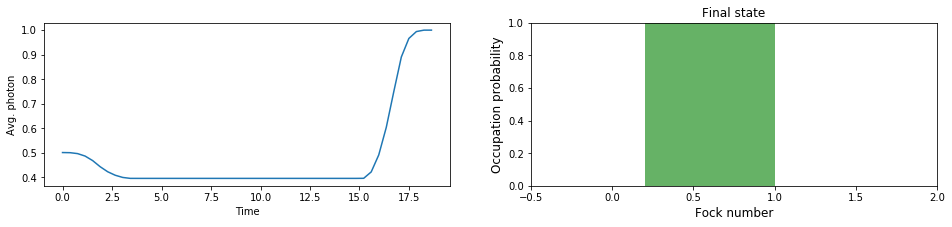

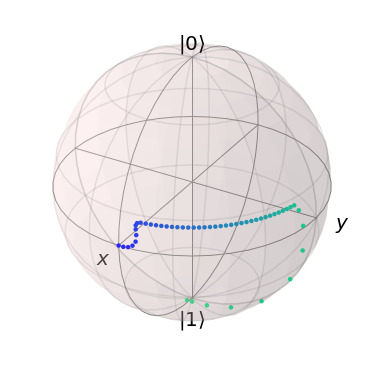

In [32]:
psi0 = (basis(2,0) + 1*basis(2,1)).unit()
myargs = {'psi0':psi0, 'z_pulse': 1, 'x_pulse': 1, 'A': 1, 'Zpi': 32, 'Xpi': 6, 'c_ops': [], 'Tpoints': 50}
results = Ypiby2_triangular(myargs,show_plot=True)

X pulse: 2.1656249366575766, Z pulse: 15.1423305995572743, Total: 19.4735804728724275
Final avg. photon = 0.9999999999998331


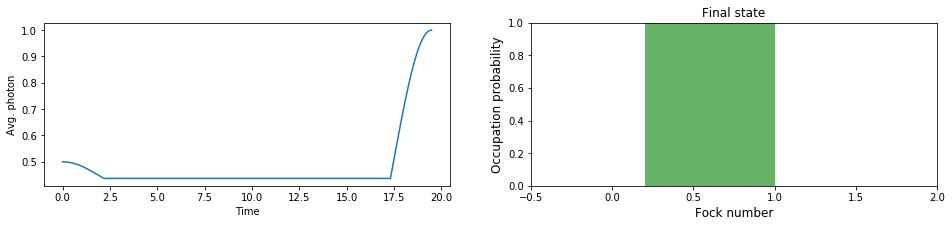

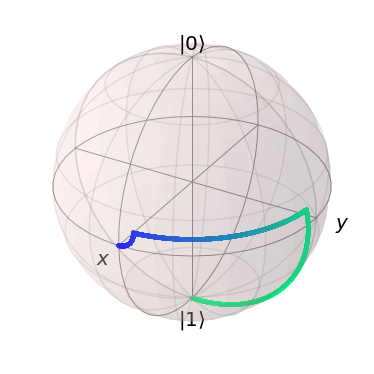

In [22]:
psi0 = (basis(2,0) + 1*basis(2,1)).unit()
# psi0 = (basis(2,1)).unit()
myargs = {'psi0':psi0, 'z_pulse': 1, 'x_pulse': 1, 'A': 1, 'Zpi': 35.71428571428572, 'Xpi': 4., 'c_ops': [], 'Tpoints': int(1e4)}
results = Ypiby2_square(myargs,show_plot=True)

## Y(pi/2) gate using zero net flux square-top pulse

In [38]:
# Ry[pi]= Rx[-x, r].Rz[z].Rx[x, r], valid for 0<= r <= sqrt(2) - 1 = 0.414

### Example

X pulse: 3.469693, Z pulse: 11.695173, Total: 18.634560
Final avg. photon = 1.000000


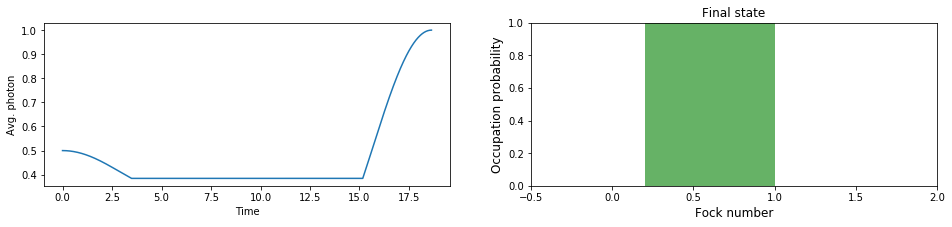

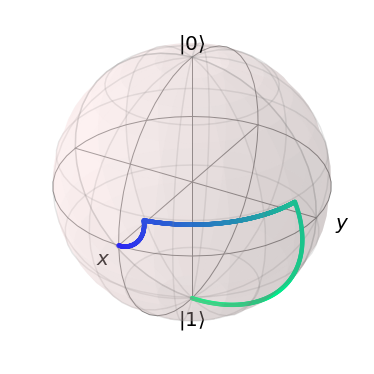

In [2]:
Zpi = 32
Xpi = 6
zbyx_rate = Xpi/Zpi

def optx(r):
    return math.acos(-r*(1+r)/(1-r))/sqrt(1 + r**2)

def optz(r):
    return 2 * math.atan(sqrt(1-2*r-2*r**3-r**4) / ((1+r)*sqrt(1 + r**2)))

x_length = optx(zbyx_rate) / pi * Xpi
z_length = optz(zbyx_rate) / pi * Zpi
Tend = 2*x_length + 1*z_length
print("X pulse: %f, Z pulse: %f, Total: %f" %(x_length,z_length,Tend))
Tpoints = 1000

sx = sigmax()
sz = sigmaz()
sm = destroy(2)

H0 = + pi/Zpi * sz/2
H1 = + pi/Xpi * sx/2

args = {'A': 0.5 *2*pi, 'wd': 1.0 * 2*pi, 'p': 0}
def H1_coeff(t, args):
    wd = args['wd']
    p = args['p']
    if t<x_length:
        return 1
    elif t>=x_length and t<x_length + z_length:
        return 0
    else:
        return -1

c_ops = []
Ht = [H0, [H1, H1_coeff]]

psi0 = (1*basis(2, 0) + 1*basis(2, 1)).unit() # initial state
tlist = np.linspace(0, Tend, Tpoints)

output = mesolve(Ht, psi0, tlist, c_ops, [], args = args)

fig, axes = plt.subplots(1, 2, figsize=(16,3))
axes[0].plot(tlist, expect(sm.dag() * sm, output.states))
axes[0].set_xlabel('Time')
axes[0].set_ylabel('Avg. photon')
plot_fock_distribution(output.states[-1], fig=fig, ax=axes[1], title="Final state");

print('Final avg. photon = %f' %(expect(sm.dag() * sm, output.states[-1])))
plot_bloch(output.states)
# # print(output.states[-1])

## Plot for paper

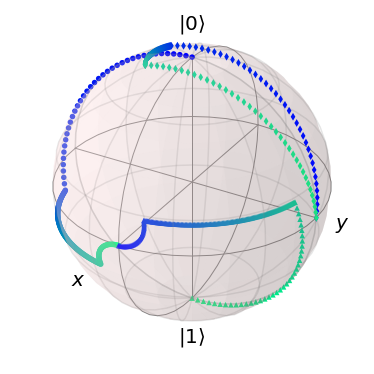

In [24]:
## Using functions: new
psi0 = (1*basis(2, 0) + 0j*basis(2, 1)).unit() # initial state
myargs = {'psi0':psi0, 'z_pulse': 1, 'x_pulse': 1, 'A': 1, 'Zpi': 32, 'Xpi': 6, 'c_ops': [], 'Tpoints': 200}
states1 = Ypiby2_square(myargs,show_plot=False)[1]

psi0 = (1*basis(2, 0) + 1*basis(2, 1)).unit() # initial state
myargs = {'psi0':psi0, 'z_pulse': 1, 'x_pulse': 1, 'A': 1, 'Zpi': 32, 'Xpi': 6, 'c_ops': [], 'Tpoints': 200}
states2 = Ypiby2_square(myargs,show_plot=False)[1]

psi0 = (1*basis(2, 0) + 1j*basis(2, 1)).unit() # initial state
myargs = {'psi0':psi0, 'z_pulse': 1, 'x_pulse': 1, 'A': 1, 'Zpi': 32, 'Xpi': 6, 'c_ops': [], 'Tpoints': 200}
states3 = Ypiby2_square(myargs,show_plot=False)[1]


b = Bloch()
b.plot_points=lambda: plot_points(b)
length = len(states1)
## normalize colors to the length of data ##
nrm = mpl.colors.Normalize(0,length)
colors = cm.winter(nrm(range(length)))
## customize sphere properties ##
b.point_color = list(colors)
b.point_marker = ['o','^','d'] # options: o, s, d, ^
b.point_size = [30]
b.size = [50,50]
b.zlpos = [1.25,-1.35]
b.xlpos = [1.5,1]

## add data points from expectation values ##
b.add_points(compute_expectation(states1),'m')
b.add_points(compute_expectation(states2),'m')
b.add_points(compute_expectation(states3),'m')

b.show()
b.save(format='svg')

X pulse: 3.469693, Z pulse: 11.695173, Total: 18.634560


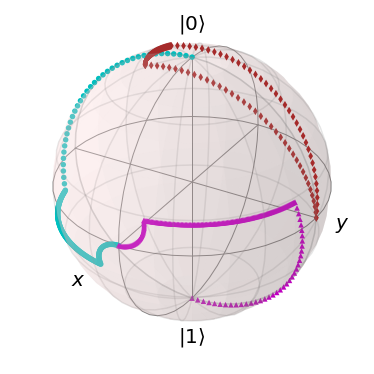

In [46]:
## Direct code: old
Zpi = 32
Xpi = 6
zbyx_rate = Xpi/Zpi

def optx(r):
    return math.acos(-r*(1+r)/(1-r))/sqrt(1 + r**2)

def optz(r):
    return 2 * math.atan(sqrt(1-2*r-2*r**3-r**4) / ((1+r)*sqrt(1 + r**2)))

x_length = optx(zbyx_rate) / pi * Xpi
z_length = optz(zbyx_rate) / pi * Zpi
Tend = 2*x_length + 1*z_length
print("X pulse: %f, Z pulse: %f, Total: %f" %(x_length,z_length,Tend))
Tpoints = 200

sx = sigmax()
sz = sigmaz()
sm = destroy(2)

H0 = + pi/Zpi * sz/2
H1 = + pi/Xpi * sx/2

args = {'A': 0.5 *2*pi, 'wd': 1.0 * 2*pi, 'p': 0}
def H1_coeff(t, args):
    wd = args['wd']
    p = args['p']
    if t<x_length:
        return 1
    elif t>=x_length and t<x_length + z_length:
        return 0
    else:
        return -1

c_ops = []
Ht = [H0, [H1, H1_coeff]]
tlist = np.linspace(0, Tend, Tpoints)

psi0 = (1*basis(2, 0) + 0j*basis(2, 1)).unit() # initial state
output1 = mesolve(Ht, psi0, tlist, c_ops, [], args = args)

psi0 = (1*basis(2, 0) + 1*basis(2, 1)).unit() # initial state
output2 = mesolve(Ht, psi0, tlist, c_ops, [], args = args)

psi0 = (1*basis(2, 0) + 1j*basis(2, 1)).unit() # initial state
output3 = mesolve(Ht, psi0, tlist, c_ops, [], args = args)

states1 = output1.states
states2 = output2.states
states3 = output3.states

b = Bloch()
b.plot_points=lambda: plot_points(b)

## normalize colors to the length of data ##
length = len(states1)
nrm = mpl.colors.Normalize(0,length)
colors = cm.winter(nrm(range(length)))

## customize sphere properties ##
# b.point_color = list(colors)
b.point_color = ['c','m','brown']
b.point_marker = ['o','^','d'] # options: o, s, d, ^
b.point_size = [30]
b.size = [50,50]
b.zlpos = [1.25,-1.35]
b.xlpos = [1.5,1]

## add data points from expectation values ##
b.add_points([expect(sigmax(), states1),
              expect(sigmay(), states1),
              expect(sigmaz(), states1)],'s')

## add data points from expectation values ##
b.add_points([expect(sigmax(), states2),
              expect(sigmay(), states2),
              expect(sigmaz(), states2)],'s')

## add data points from expectation values ##
b.add_points([expect(sigmax(), states3),
              expect(sigmay(), states3),
              expect(sigmaz(), states3)],'s')

b.show()
b.save(format='svg')

In [47]:
def sweep_1D(args, sweep_arg, sweep_pts, show_plot=False):
#     with Pool(processes=2) as p:
#         def func(val):
#             print('Here')
#             fargs=args.copy()
#             fargs[sweep_arg]=val
#             return basis(2,0) #Ypiby2_triangular(fargs, show_plot=False)[-1][-1]
#         states=p.map(func, sweep_pts)
    
    states = []
    for ii, val in enumerate(sweep_pts):
        args[sweep_arg]=val
        states.append(evolve_fluxonium_square(args, show_plot=False)[-1][-1])
    
    if show_plot:
        ps=transpose([compute_expectation(s) for s in states])
        subplot(111,xlabel=sweep_arg, ylabel='$\sigma_i$')
        for p,l in zip(ps,['X','Y','Z']):
            plot(sweep_pts,p.real,label=l)
        legend()
        grid()
        ylim(-1,1)
    return states

def sweep_2D(myargs,argX, argY, Xpts,Ypts,show_plot=False):
    xypts=[]
    for y in Ypts:
        for x in Xpts:
            xypts.append((x,y))
    
#     with Pool(processes=6) as p:
#         def func(xy):
#             fargs=myargs.copy()
#             fargs[argX]=xy[0]
#             fargs[argY]=xy[1]
#             return evolve_fluxonium_triangular(fargs, show_plot=False)[-1][-1])
#         us=p.map(func, xypts)
    
    states = []
    for ii, xy in enumerate(xypts):
        fargs=myargs.copy()
        fargs[argX]=xy[0]
        fargs[argY]=xy[1]
        states.append(evolve_fluxonium_triangular(fargs, show_plot=False)[-1][-1])
        
    if show_plot:
        X,Y = meshgrid(Xpts,Ypts)
        ps=reshape(transpose([compute_expectation(s) for s in states]),(3,len(Ypts),len(Xpts)))
        figure(figsize=(12,4))
        for ii,(p,l) in enumerate(zip(ps,['<X>','<Y>','<Z>'])):
            subplot(131+ii,xlabel=argX,ylabel=argY,title=l)
            pcolormesh(X,Y,p)
            clim(-1,1)
            colorbar()
        tight_layout()
        savefig("sweep.pdf")
    return reshape(states,(len(Ypts),len(Xpts)))


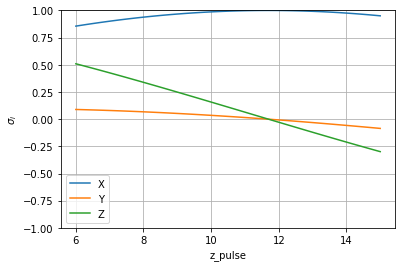

In [15]:
# 1D sweep example
psi0 = (basis(2,0) - 0j*basis(2,1)).unit()
myargs = {'psi0':psi0, 'z_pulse': 15, 'x_pulse': 3.4697, 'A': 1, 'Zpi': 32, 'Xpi': 6, 'c_ops': [], 'Tpoints': 50}

zpts=linspace(6,15,101)
s1=sweep_1D(myargs,'z_pulse',zpts,show_plot=True)

Time taken: 252.982427


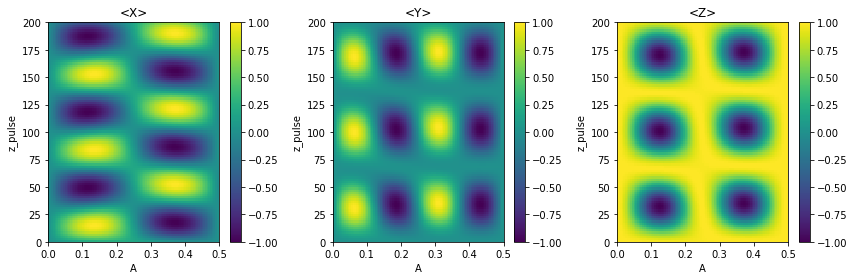

In [49]:
# 2D sweep example
psi0 = (basis(2,0) - 0j*basis(2,1)).unit()
myargs = {'psi0':psi0, 'z_pulse': 15, 'x_pulse': 2.381, 'A': 1, 'Zpi': 34.5, 'Xpi': 0.588, 'c_ops': [], 'Tpoints': 50}

apts=linspace(0,0.5,101)
zpts=linspace(0,200,101)

tm = time.time()
myus=sweep_2D(myargs,'A','z_pulse',apts,zpts,show_plot=True)
print('Time taken: %f' %(time.time() - tm))

Time taken: 249.355772


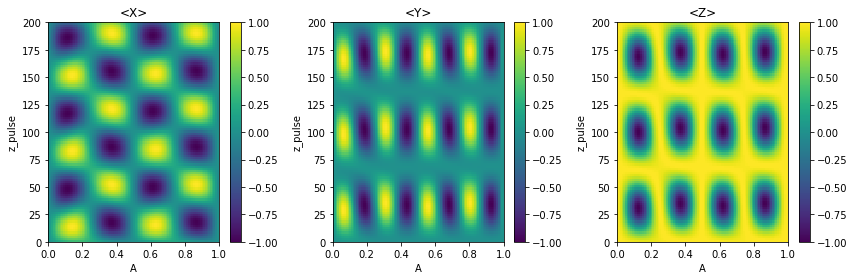

In [14]:
# 2D sweep example
psi0 = (basis(2,0) - 0j*basis(2,1)).unit()
myargs = {'psi0':psi0, 'z_pulse': 15, 'x_pulse': 3.4697, 'A': 1, 'Zpi': 34.5, 'Xpi': 0.857, 'c_ops': [], 'Tpoints': 50}

apts=linspace(0,1,101)
zpts=linspace(0,200,101)

tm = time.time()
myus=sweep_2D(myargs,'A','z_pulse',apts,zpts,show_plot=True)
print('Time taken: %f' %(time.time() - tm))

Time taken: 562.089868


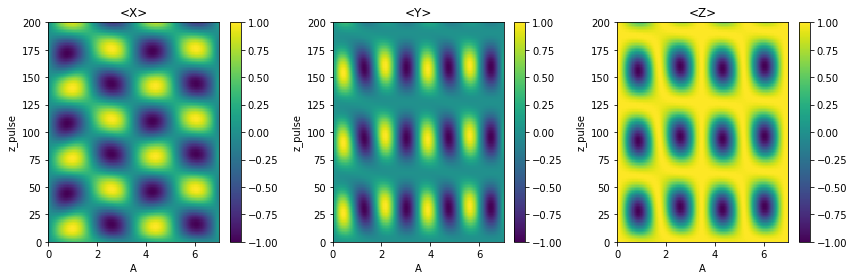

In [6]:
# 2D sweep example
psi0 = (basis(2,0) - 0j*basis(2,1)).unit()
myargs = {'psi0':psi0, 'z_pulse': 15, 'x_pulse': 3.4697, 'A': 1, 'Zpi': 32, 'Xpi': 6, 'c_ops': [], 'Tpoints': 50}

apts=linspace(0,7,151)
zpts=linspace(0,200,151)

tm = time.time()
myus=sweep_2D(myargs,'A','z_pulse',apts,zpts,show_plot=True)
print('Time taken: %f' %(time.time() - tm))

In [ ]:
a=2
print((a**n)**2)
for n in range(25):
    num = a**(2*n)
    print('%s: %s,%s' %(num, int((num-1)/3), (num-1)%3))

In [66]:
bin(10)

'0b1010'

In [68]:
print(int('111111111',2))
print(int('111',2))
print(format(10, 'b'))

511
7
1010


In [72]:
for n in range(25):
    print('%s: %s: %s' %(2*n+1, format(2*n+1, 'b'), format(3*(2*n+1), 'b')))

1: 1: 11
3: 11: 1001
5: 101: 1111
7: 111: 10101
9: 1001: 11011
11: 1011: 100001
13: 1101: 100111
15: 1111: 101101
17: 10001: 110011
19: 10011: 111001
21: 10101: 111111
23: 10111: 1000101
25: 11001: 1001011
27: 11011: 1010001
29: 11101: 1010111
31: 11111: 1011101
33: 100001: 1100011
35: 100011: 1101001
37: 100101: 1101111
39: 100111: 1110101
41: 101001: 1111011
43: 101011: 10000001
45: 101101: 10000111
47: 101111: 10001101
49: 110001: 10010011


In [64]:
for n in range(25):
    num = 2**(4*n)
    print('%s: %s' %(num, (num-1)%15))

1: 0
16: 0
256: 0
4096: 0
65536: 0
1048576: 0
16777216: 0
268435456: 0
4294967296: 0
68719476736: 0
1099511627776: 0
17592186044416: 0
281474976710656: 0
4503599627370496: 0
72057594037927936: 0
1152921504606846976: 0
18446744073709551616: 0
295147905179352825856: 0
4722366482869645213696: 0
75557863725914323419136: 0
1208925819614629174706176: 0
19342813113834066795298816: 0
309485009821345068724781056: 0
4951760157141521099596496896: 0
79228162514264337593543950336: 0


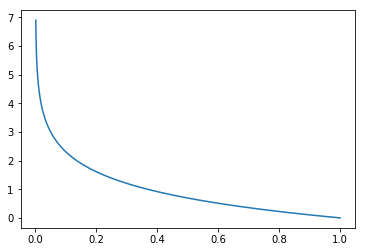

In [81]:
xdata = arange(0,7,0.1);
ydata = np.exp(-xdata);
plot(ydata, xdata)